          video_id trending_date  \
0      2kyS6SvSYSE      17.14.11   
1      1ZAPwfrtAFY      17.14.11   
2      5qpjK5DgCt4      17.14.11   
3      puqaWrEC7tY      17.14.11   
4      d380meD0W0M      17.14.11   
...            ...           ...   
40944  BZt0qjTWNhw      18.14.06   
40945  1h7KV2sjUWY      18.14.06   
40946  D6Oy4LfoqsU      18.14.06   
40947  oV0zkMe1K8s      18.14.06   
40948  ooyjaVdt-jA      18.14.06   

                                                   title  \
0                     WE WANT TO TALK ABOUT OUR MARRIAGE   
1      The Trump Presidency: Last Week Tonight with J...   
2      Racist Superman | Rudy Mancuso, King Bach & Le...   
3                       Nickelback Lyrics: Real or Fake?   
4                               I Dare You: GOING BALD!?   
...                                                  ...   
40944                       The Cat Who Caught the Laser   
40945                         True Facts : Ant Mutualism   
40946  I GAVE SAFIYA NYGAAR

C:\Users\ANUSHKA\AppData\Local\Temp\ipykernel_2864\1591271244.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


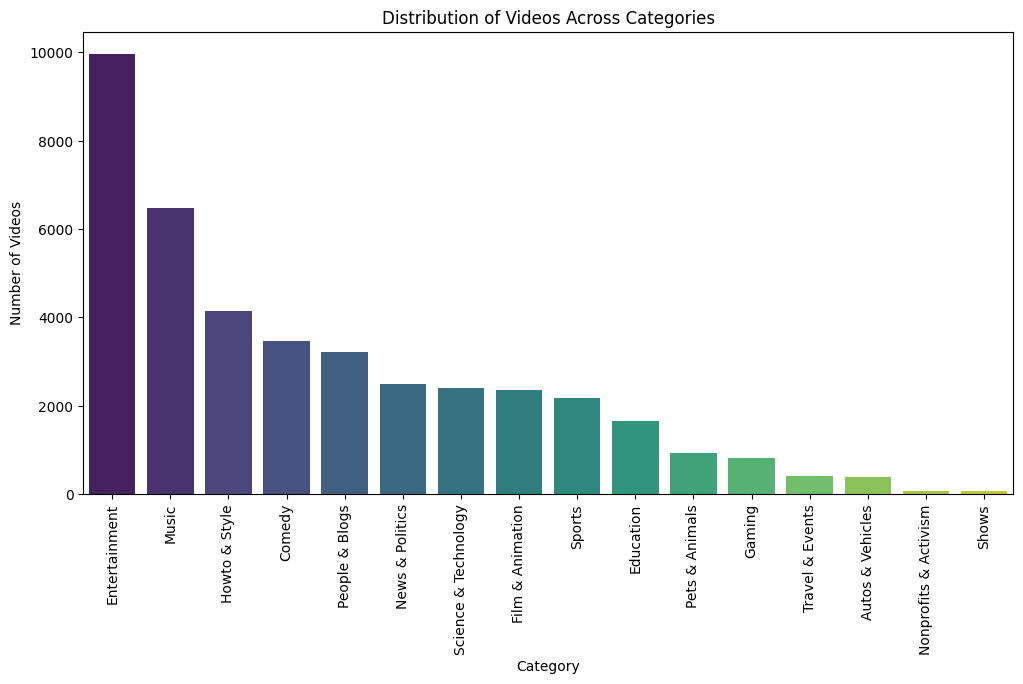

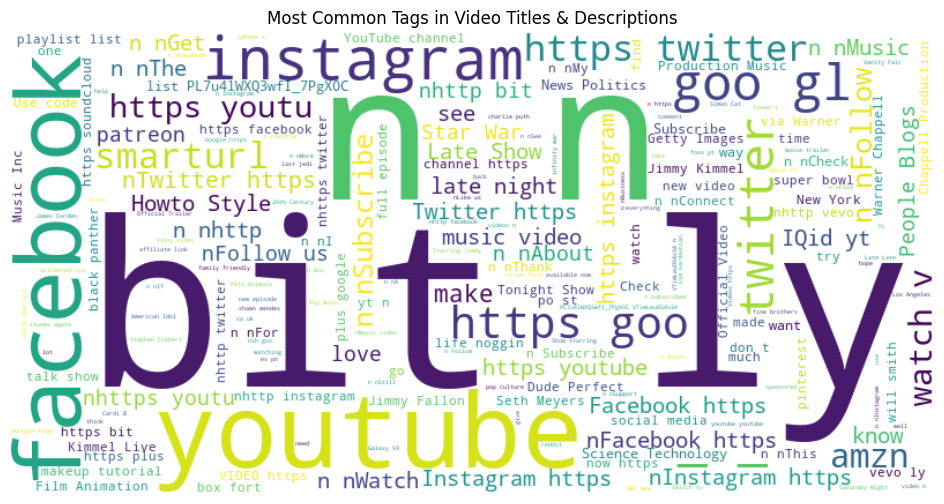

C:\Users\ANUSHKA\AppData\Local\Temp\ipykernel_2864\1591271244.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_channels.values, y=top_channels.index, palette="coolwarm")


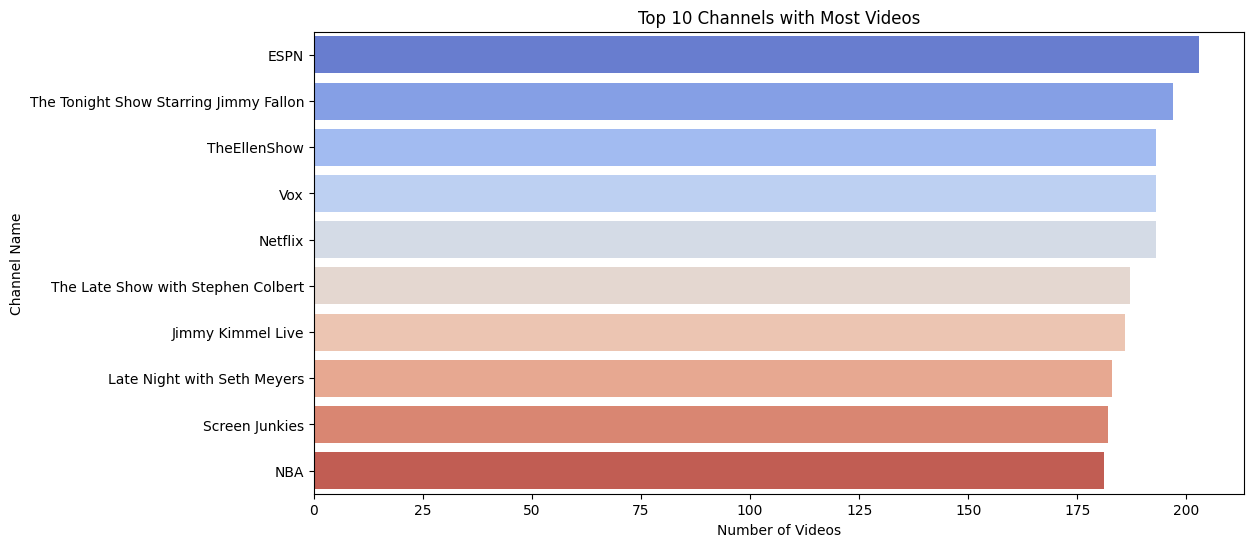

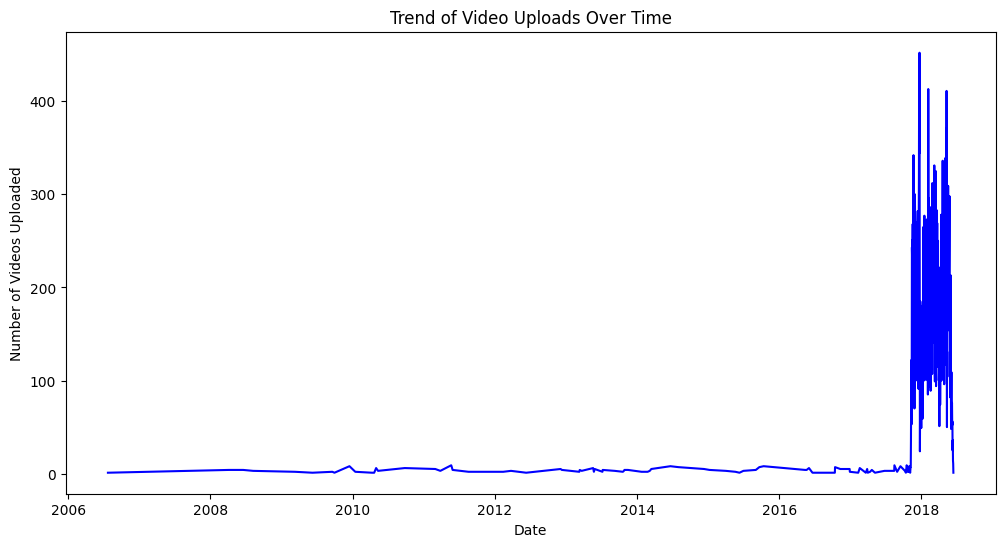

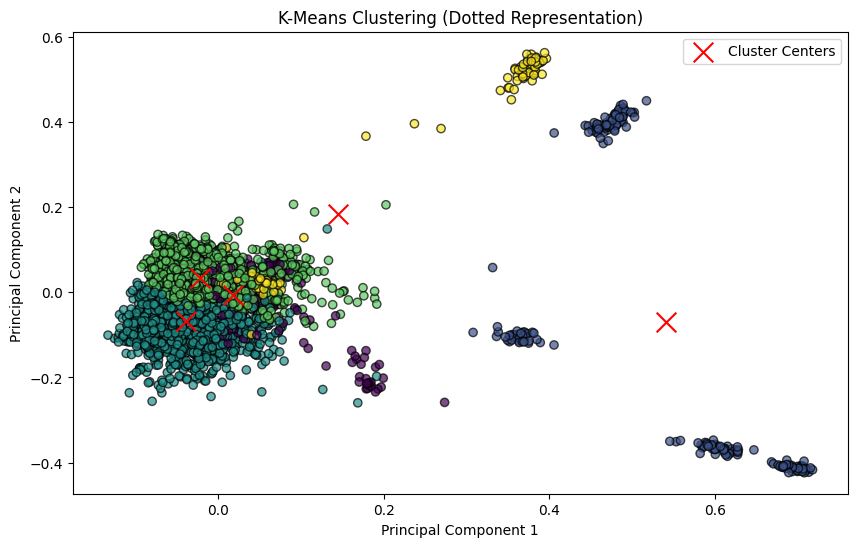

[('Entertainment', 9964), ('Music', 6472), ('Howto & Style', 4146), ('Comedy', 3457), ('People & Blogs', 3210)]
Counter({3: 3531, 2: 2039, 0: 457, 4: 215, 1: 213})


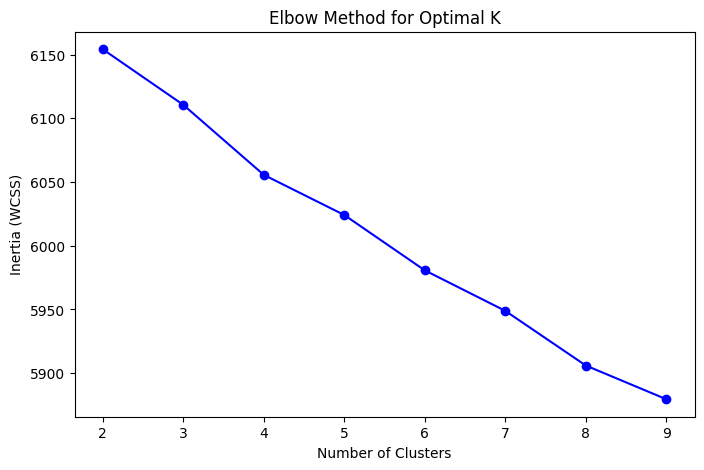

K=2, Silhouette Score=0.0077
K=3, Silhouette Score=0.0089
K=4, Silhouette Score=0.0117
K=5, Silhouette Score=0.0140
K=6, Silhouette Score=0.0180
K=7, Silhouette Score=0.0184
K=8, Silhouette Score=0.0233
K=9, Silhouette Score=0.0236


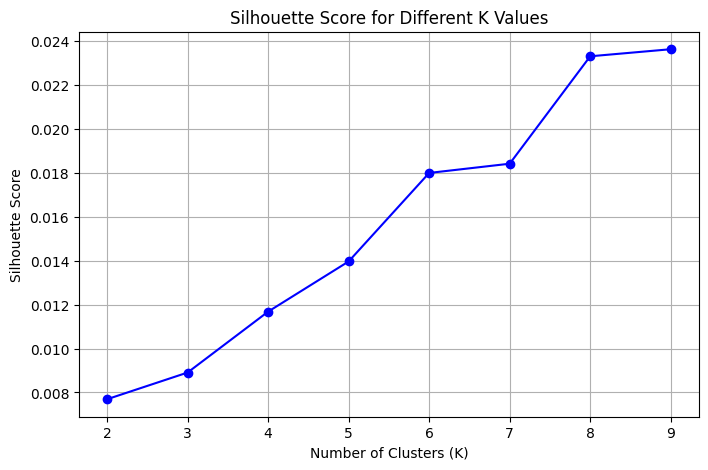

Model and data saved successfully!


In [18]:
# For Data Handling & Preprocessing
import numpy as np
import pandas as pd
import pickle
import json
import re
from datetime import datetime

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# For Text Processing & Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# For Clustering
from sklearn.cluster import KMeans

# For Dimensionality Reduction
from sklearn.decomposition import PCA

# For Model Evaluation & Metrics
from sklearn.metrics import silhouette_score
from collections import Counter



# Load dataset
df = pd.read_csv('USvideos.csv')
json_file = 'US_category_id.json'

# Load JSON category mapping
with open(json_file, "r", encoding="utf-8") as f:
    json_data = json.load(f)
category_mapping = {item["id"]: item["snippet"]["title"] for item in json_data["items"]}
df["category_id"] = df["category_id"].astype(str)
df["category_name"] = df["category_id"].map(category_mapping)

print(df)

df.info()

df.isna().sum()

df["description"] = df["description"].fillna("")
df.isna().sum()

df.describe()

#Graph and Visualization
plt.figure(figsize=(12, 6))
category_counts = df["category_name"].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Number of Videos")
plt.title("Distribution of Videos Across Categories")
plt.show()



# Create 'tags' column combining title, channel, tags, and category
df["tags"] = df["channel_title"] + " " + df["tags"] + " " + df["category_name"] + " " + df["description"]
df["tags"] = df["tags"].fillna("")
text = " ".join(df["tags"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Tags in Video Titles & Descriptions")
plt.show()

plt.figure(figsize=(12, 6))
top_channels = df["channel_title"].value_counts().nlargest(10)
sns.barplot(x=top_channels.values, y=top_channels.index, palette="coolwarm")
plt.xlabel("Number of Videos")
plt.ylabel("Channel Name")
plt.title("Top 10 Channels with Most Videos")
plt.show()

df["publishedAt"] = pd.to_datetime(df["publish_time"])  # Convert to datetime format
df["upload_date"] = df["publishedAt"].dt.date  # Extract date part

plt.figure(figsize=(12, 6))
df.groupby("upload_date").size().plot(kind="line", color="blue")
plt.xlabel("Date")
plt.ylabel("Number of Videos Uploaded")
plt.title("Trend of Video Uploads Over Time")
plt.show()




#Creating a compact dataframe

# Select required columns
df["tags"] = df["channel_title"] + " " + df["tags"] + " " + df["category_name"] + " " + df["description"]

df_new = df[["video_id", "title", "tags", "thumbnail_link"]].drop_duplicates(subset=['title'], keep="first")

# Clean text

def clean_text(text):
    if pd.isna(text):  
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)  # Remove URLs
    text = re.sub(r"[\n;,-]", " ", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

df_new["tags"] = df_new["tags"].apply(clean_text)

# Combine title and tags for vectorization
df_new["combined_text"] = df_new["title"] + " " + df_new["tags"]


# **Vectorize using TF-IDF**
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_new["combined_text"])  # Create TF-IDF matrix

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())  # Convert sparse matrix to dense

# Apply K-Means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df_new["cluster"] = kmeans.fit_predict(X)

# Scatter plot for clustering visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_new["cluster"], cmap="viridis", marker="o", edgecolors="k", alpha=0.7)

# Add cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c="red", marker="x", s=200, label="Cluster Centers")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering (Dotted Representation)")
plt.legend()
plt.show()



# Count videos per category
category_counts = Counter(df["category_name"])
print(category_counts.most_common(5))  # Top 5 most frequent categories

# Count videos per cluster
cluster_counts = Counter(df_new["cluster"])
print(cluster_counts)



inertia = []
K = range(2, 10)  

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.show()




k_values = list(range(2, 10))
silhouette_scores = []

# Compute Silhouette Score for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")  # Print scores

# Plot Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K Values")
plt.grid(True)
plt.show()




# **Save the vectorizer and dataframe using pickle**
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("video_data.pkl", "wb") as f:
    pickle.dump(df_new, f)

with open("pickel_matrix.pkl", "wb") as f:
    pickle.dump(X, f)

print("Model and data saved successfully!")
